In [1]:
### General
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import astropy
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, Column, vstack, join, unique
from astroquery.gaia import Gaia
from astroquery.sdss import SDSS

### Tools
import sys
sys.path.append('../')
import wdphoto
from wdphoto import LaPlataInterpolator, WarwickDAInterpolator, PhotometryEngine, deredden

from astroquery.vizier import Vizier

In [2]:
# https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/A%2bA/658/A22/table5
catalog = Table.read('raddi.csv')

In [3]:
print(len(catalog))

2119


In [4]:
bands = ['Gaia_RP', 'Gaia_BP']#, 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z']

warwick = WarwickDAInterpolator(bands)
baseline = LaPlataInterpolator(bands)
co_hrich = LaPlataInterpolator(bands, massive_params = ('CO', 'Hrich'))
co_hdef = LaPlataInterpolator(bands, massive_params = ('CO', 'Hdef'))
one_hrich = LaPlataInterpolator(bands, massive_params = ('ONe', 'Hrich'))
one_hdef = LaPlataInterpolator(bands, massive_params = ('ONe', 'Hdef'))

WarwickEngine = PhotometryEngine(warwick)
BaselineEngine = PhotometryEngine(baseline)
CO_HrichEngine = PhotometryEngine(co_hrich)
CO_HdefEngine = PhotometryEngine(co_hdef)
ONe_HrichEngine = PhotometryEngine(one_hrich)
ONe_HdefEngine = PhotometryEngine(one_hdef)

In [5]:
for i in range(len(catalog)):
    catalog['Radius'][i] = baseline.radius_interp(catalog['teff'][i], catalog['logg'][i])

In [6]:
catalog = catalog[~np.isnan(catalog['Radius'])]
obs_mag = np.array(catalog[['phot_rp_mean_mag', 'phot_bp_mean_mag']])#, 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z']])
e_obs_mag = np.array(catalog[['e_rpmag', 'e_bpmag']])#, 'psfMagErr_u', 'psfMagErr_g', 'psfMagErr_r', 'psfMagErr_i', 'psfMagErr_z']])
distances = np.array(catalog['r_med_geo'])

In [7]:
i = 2
print(catalog[['Radius', 'teff', 'logg']][i])
print(BaselineEngine(obs_mag[i], e_obs_mag[i], distances[i]))

       Radius           teff   logg
-------------------- --------- ----
0.013493553038645429 12331.048 7.93
(0.014415743757646593, 9.271089741001669e-07, 11888.0535339551, 0.6239681613852617, 3.140926507998374e-14)


In [8]:
outs = np.nan*np.zeros((6, len(obs_mag), 5))

for i in tqdm(range(len(obs_mag))):
    aaaaaaaaaa = BaselineEngine(obs_mag[i], e_obs_mag[i], distances[i])#, p0=[catalog['teff'][i], catalog['logg'][i], 0.003])
    outs[0,i] = aaaaaaaaaa[:4] + (aaaaaaaaaa[-1],)
    outs[1,i] = CO_HrichEngine(obs_mag[i], e_obs_mag[i], distances[i])
    outs[2,i] = CO_HdefEngine(obs_mag[i], e_obs_mag[i], distances[i])
    outs[3,i] = ONe_HrichEngine(obs_mag[i], e_obs_mag[i], distances[i])
    outs[4,i] = ONe_HdefEngine(obs_mag[i], e_obs_mag[i], distances[i])
    outs[5,i] = WarwickEngine(obs_mag[i], e_obs_mag[i], distances[i])

100%|██████████| 2119/2119 [08:21<00:00,  4.23it/s]


In [9]:
catalog.rename_column('Radius', 'Raddi_radius')

catalog['Baseline_radius'] = outs[0,:,0]
catalog['Baseline_e_radius'] = outs[0,:,1]
catalog['Baseline_teff'] = outs[0,:,2]
catalog['Baseline_e_teff'] = outs[0,:,3]
catalog['Baseline_chi2'] = outs[0,:,-1]
catalog['Baseline_roe'] = catalog['Baseline_radius'] / catalog['Baseline_e_radius']

catalog['CO_Hrich_radius'] = outs[1,:,0]
catalog['CO_Hrich_e_radius'] = outs[1,:,1]
catalog['CO_Hrich_teff'] = outs[1,:,2]
catalog['CO_Hrich_e_teff'] = outs[1,:,3]
catalog['CO_Hrich_chi2'] = outs[1,:,-1]
catalog['CO_Hrich_roe'] = catalog['CO_Hrich_radius']/catalog['CO_Hrich_e_radius']

catalog['CO_Hdef_radius'] = outs[2,:,0]
catalog['CO_Hdef_e_radius'] = outs[2,:,1]
catalog['CO_Hdef_teff'] = outs[2,:,2]
catalog['CO_Hdef_e_teff'] = outs[2,:,3]
catalog['CO_Hdef_chi2'] = outs[2,:,-1]
catalog['CO_Hdef_roe'] = catalog['CO_Hdef_radius']/catalog['CO_Hdef_e_radius']

catalog['ONe_Hrich_radius'] = outs[3,:,0]
catalog['ONe_Hrich_e_radius'] = outs[3,:,1]
catalog['ONe_Hrich_teff'] = outs[3,:,2]
catalog['ONe_Hrich_e_teff'] = outs[3,:,3]
catalog['ONe_Hrich_chi2'] = outs[3,:,-1]
catalog['ONe_Hrich_roe'] = catalog['ONe_Hrich_radius']/catalog['ONe_Hrich_e_radius']

catalog['ONe_Hdef_radius'] = outs[4,:,0]
catalog['ONe_Hdef_e_radius'] = outs[4,:,1]
catalog['ONe_Hdef_teff'] = outs[4,:,2]
catalog['ONe_Hdef_e_teff'] = outs[4,:,3]
catalog['ONe_Hdef_chi2'] = outs[4,:,-1]
catalog['ONe_Hdef_roe'] = catalog['ONe_Hdef_radius']/catalog['ONe_Hdef_e_radius']

catalog['Warwick_radius'] = outs[5,:,0]
catalog['Warwick_e_radius'] = outs[5,:,1]
catalog['Warwick_teff'] = outs[5,:,2]
catalog['Warwick_e_teff'] = outs[5,:,3]
catalog['Warwick_chi2'] = outs[5,:,-1]
catalog['Warwick_roe'] = catalog['Warwick_radius']/catalog['Warwick_e_radius']

In [10]:
Baseline_failed = np.any([catalog['Baseline_chi2'] > 5, catalog['Baseline_roe'] < 5], axis=0)
CO_Hrich_failed = np.any([catalog['CO_Hrich_chi2'] > 5, catalog['CO_Hrich_roe'] < 5], axis=0)
CO_Hdef_failed = np.any([catalog['CO_Hdef_chi2'] > 5, catalog['CO_Hdef_roe'] < 5], axis=0)
ONe_Hrich_failed = np.any([catalog['ONe_Hrich_chi2'] > 5, catalog['ONe_Hrich_roe'] < 5], axis=0)
ONe_Hdef_failed = np.any([catalog['ONe_Hdef_chi2'] > 5, catalog['ONe_Hdef_roe'] < 5], axis=0)
Warwick_failed = np.any([catalog['Warwick_chi2'] > 5, catalog['Warwick_roe'] < 5], axis=0)

In [11]:
print(f'Baseline_failed={len(catalog[Baseline_failed])/len(catalog)*100:2.2f}%')
print(f'CO_Hrich_failed={len(catalog[CO_Hrich_failed])/len(catalog)*100:2.2f}%')
print(f'CO_Hdef_failed={len(catalog[CO_Hdef_failed])/len(catalog)*100:2.2f}%')
print(f'ONe_Hrich_failed={len(catalog[ONe_Hrich_failed])/len(catalog)*100:2.2f}%')
print(f'ONe_Hdef_failed={len(catalog[ONe_Hdef_failed])/len(catalog)*100:2.2f}%')
print(f'Warwick_failed={len(catalog[Warwick_failed])/len(catalog)*100:2.2f}%')


mask = np.all([~Baseline_failed, ~CO_Hrich_failed, ~CO_Hdef_failed,
               ~ONe_Hrich_failed, ~ONe_Hdef_failed], axis=0)
print(f'\nTotal failed={(1-len(catalog[mask])/len(catalog))*100:2.2f}%')

Baseline_failed=2.36%
CO_Hrich_failed=17.93%
CO_Hdef_failed=7.46%
ONe_Hrich_failed=8.64%
ONe_Hdef_failed=9.44%
Warwick_failed=2.55%

Total failed=35.30%


Text(0, 0.5, 'CO_Hrich Radius')

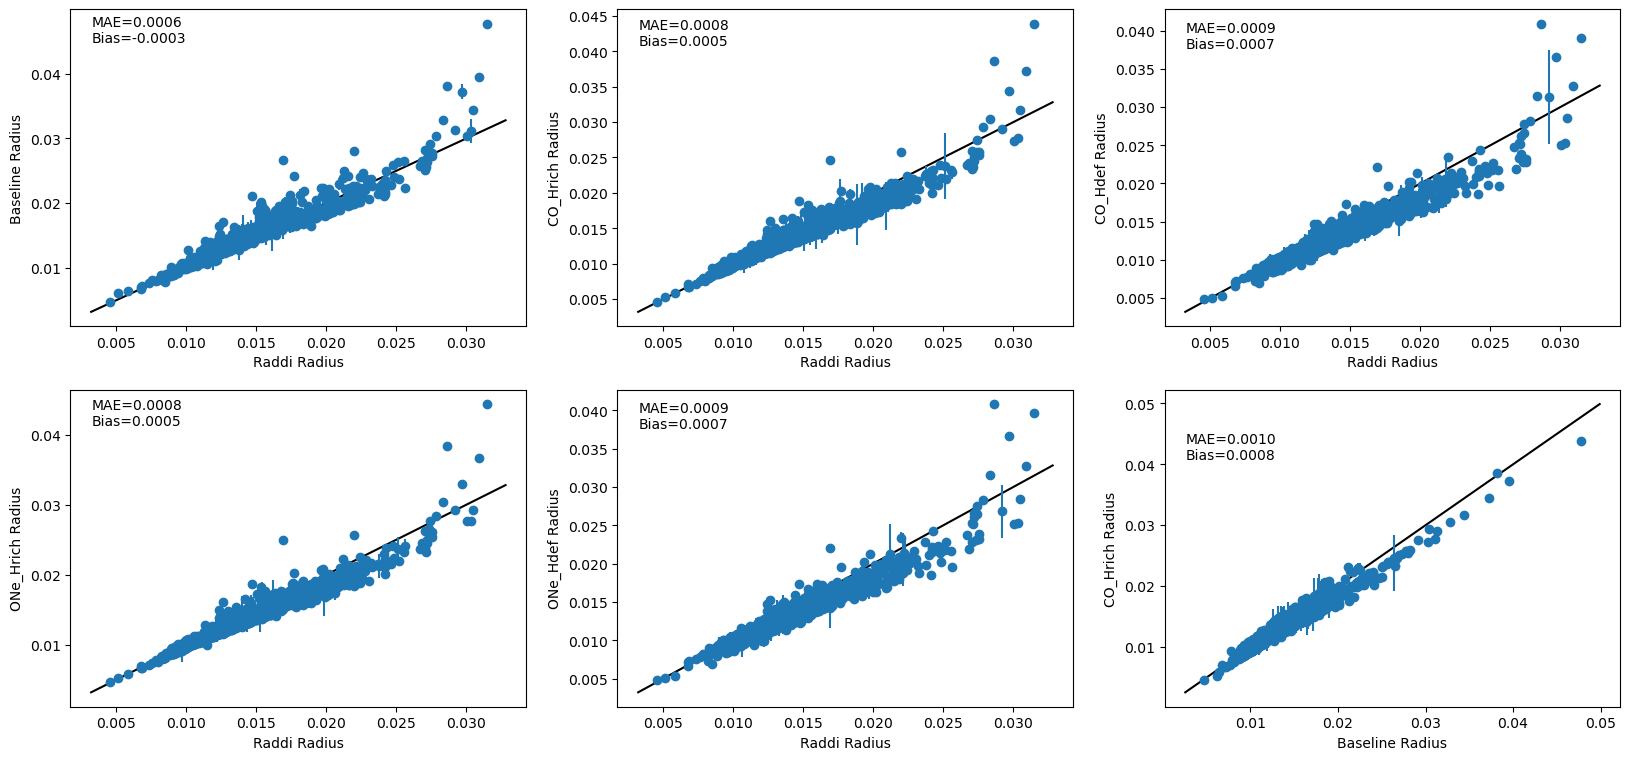

In [26]:
plt.figure(figsize=(20,14))

plt.subplot(331)
mae = np.sum(np.abs(catalog[mask]['Raddi_radius'] - catalog[mask]['Baseline_radius'])) / len(catalog[mask])
bias = np.average(catalog[mask]['Raddi_radius'] - catalog[mask]['Baseline_radius'])
plt.errorbar(catalog[mask]['Raddi_radius'], catalog[mask]['Baseline_radius'], yerr=catalog[mask]['Baseline_e_radius'], fmt='o')
xlims = plt.xlim()
ylims = plt.ylim()
plt.text(xlims[0], ylims[1]-0.005, f'MAE={mae:2.4f}\nBias={bias:2.4f}')
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Raddi Radius')
plt.ylabel('Baseline Radius')

plt.subplot(332)
mae = np.sum(np.abs(catalog[mask]['Raddi_radius'] - catalog[mask]['CO_Hrich_radius'])) / len(catalog[mask])
bias = np.average(catalog[mask]['Raddi_radius'] - catalog[mask]['CO_Hrich_radius'])
plt.errorbar(catalog[mask]['Raddi_radius'], catalog[mask]['CO_Hrich_radius'], yerr=catalog[mask]['CO_Hrich_e_radius'], fmt='o')
xlims = plt.xlim()
ylims = plt.ylim()
plt.text(xlims[0], ylims[1]-0.005, f'MAE={mae:2.4f}\nBias={bias:2.4f}')
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Raddi Radius')
plt.ylabel('CO_Hrich Radius')

plt.subplot(333)
mae = np.sum(np.abs(catalog[mask]['Raddi_radius'] - catalog[mask]['CO_Hdef_radius'])) / len(catalog[mask])
bias = np.average(catalog[mask]['Raddi_radius'] - catalog[mask]['CO_Hdef_radius'])
plt.errorbar(catalog[mask]['Raddi_radius'], catalog[mask]['CO_Hdef_radius'], yerr=catalog[mask]['CO_Hdef_e_radius'], fmt='o')
xlims = plt.xlim()
ylims = plt.ylim()
plt.text(xlims[0], ylims[1]-0.005, f'MAE={mae:2.4f}\nBias={bias:2.4f}')
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Raddi Radius')
plt.ylabel('CO_Hdef Radius')

plt.subplot(334)
mae = np.sum(np.abs(catalog[mask]['Raddi_radius'] - catalog[mask]['ONe_Hrich_radius'])) / len(catalog[mask])
bias = np.average(catalog[mask]['Raddi_radius'] - catalog[mask]['ONe_Hrich_radius'])
plt.errorbar(catalog[mask]['Raddi_radius'], catalog[mask]['ONe_Hrich_radius'], yerr=catalog[mask]['ONe_Hrich_e_radius'], fmt='o')
xlims = plt.xlim()
ylims = plt.ylim()
plt.text(xlims[0], ylims[1]-0.005, f'MAE={mae:2.4f}\nBias={bias:2.4f}')
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Raddi Radius')
plt.ylabel('ONe_Hrich Radius')

plt.subplot(335)
mae = np.sum(np.abs(catalog[mask]['Raddi_radius'] - catalog[mask]['ONe_Hdef_radius'])) / len(catalog[mask])
bias = np.average(catalog[mask]['Raddi_radius'] - catalog[mask]['ONe_Hdef_radius'])
plt.errorbar(catalog[mask]['Raddi_radius'], catalog[mask]['ONe_Hdef_radius'], yerr=catalog[mask]['ONe_Hdef_e_radius'], fmt='o')
xlims = plt.xlim()
ylims = plt.ylim()
plt.text(xlims[0], ylims[1]-0.005, f'MAE={mae:2.4f}\nBias={bias:2.4f}')
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Raddi Radius')
plt.ylabel('ONe_Hdef Radius')

plt.subplot(336)
mae = np.sum(np.abs(catalog[mask]['Baseline_radius'] - catalog[mask]['CO_Hrich_radius'])) / len(catalog[mask])
bias = np.average(catalog[mask]['Baseline_radius'] - catalog[mask]['CO_Hrich_radius'])
plt.errorbar(catalog[mask]['Baseline_radius'], catalog[mask]['CO_Hrich_radius'], yerr=catalog[mask]['CO_Hrich_e_radius'], fmt='o')
xlims = plt.xlim()
ylims = plt.ylim()
plt.text(xlims[0], ylims[1]-0.005, f'MAE={mae:2.4f}\nBias={bias:2.4f}')
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Baseline Radius')
plt.ylabel('CO_Hrich Radius')

Text(0, 0.5, 'Raddi Radius')

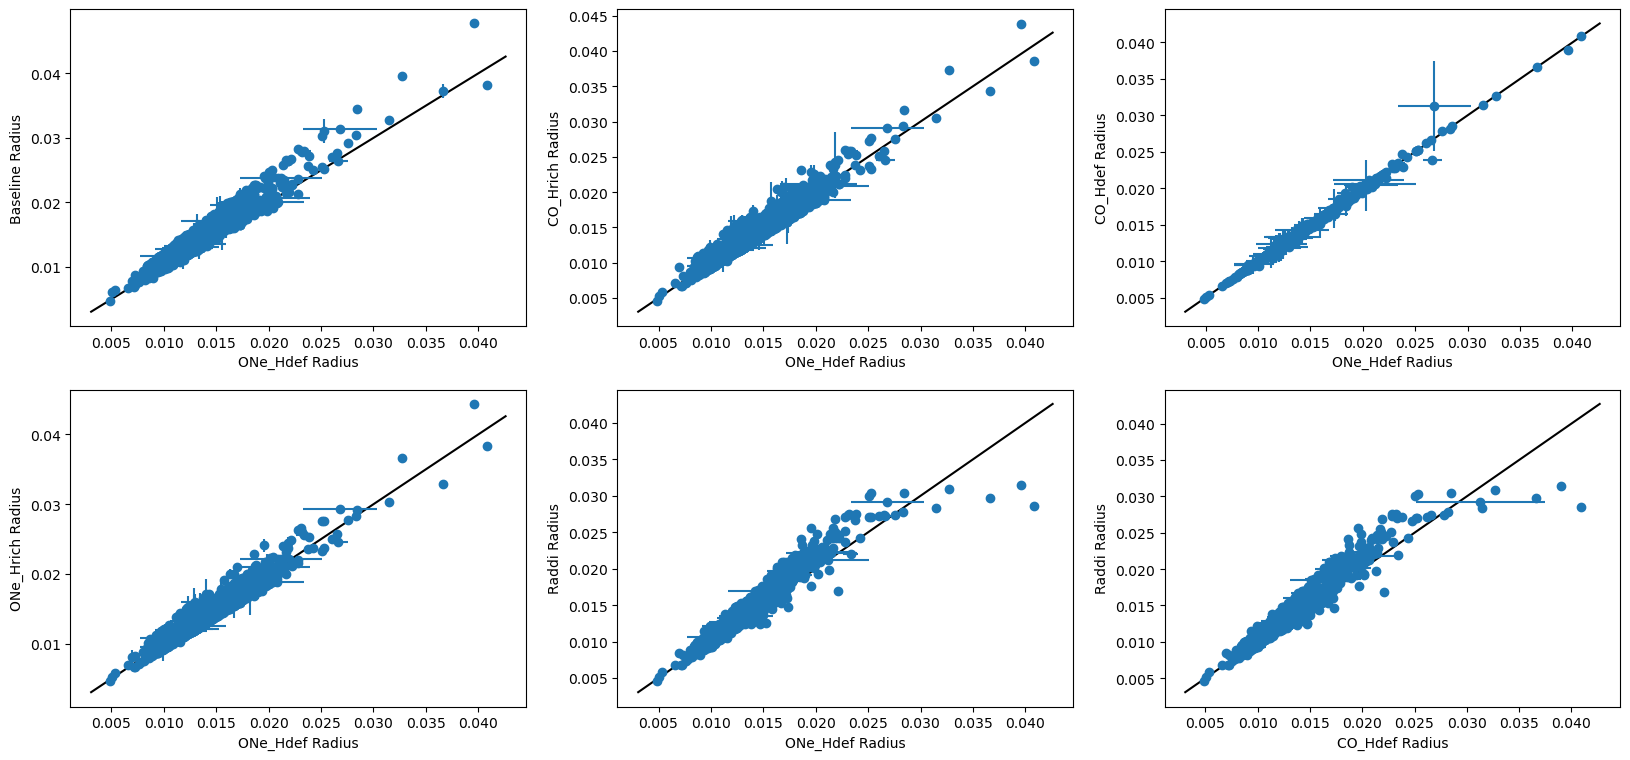

In [13]:
plt.figure(figsize=(20,14))

plt.subplot(331)
plt.errorbar(catalog[mask]['ONe_Hdef_radius'], catalog[mask]['Baseline_radius'], 
             xerr = catalog[mask]['ONe_Hdef_e_radius'], yerr=catalog[mask]['Baseline_e_radius'], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('ONe_Hdef Radius')
plt.ylabel('Baseline Radius')

plt.subplot(332)
plt.errorbar(catalog[mask]['ONe_Hdef_radius'], catalog[mask]['CO_Hrich_radius'], 
             xerr = catalog[mask]['ONe_Hdef_e_radius'], yerr=catalog[mask]['CO_Hrich_e_radius'], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('ONe_Hdef Radius')
plt.ylabel('CO_Hrich Radius')

plt.subplot(333)
plt.errorbar(catalog[mask]['ONe_Hdef_radius'], catalog[mask]['CO_Hdef_radius'], 
             xerr = catalog[mask]['ONe_Hdef_e_radius'], yerr=catalog[mask]['CO_Hdef_e_radius'], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('ONe_Hdef Radius')
plt.ylabel('CO_Hdef Radius')

plt.subplot(334)
plt.errorbar(catalog[mask]['ONe_Hdef_radius'], catalog[mask]['ONe_Hrich_radius'], 
             xerr = catalog[mask]['ONe_Hdef_e_radius'], yerr=catalog[mask]['ONe_Hrich_e_radius'], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('ONe_Hdef Radius')
plt.ylabel('ONe_Hrich Radius')

plt.subplot(335)
plt.errorbar(catalog[mask]['ONe_Hdef_radius'], catalog[mask]['Raddi_radius'], 
             xerr = catalog[mask]['ONe_Hdef_e_radius'], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('ONe_Hdef Radius')
plt.ylabel('Raddi Radius')

plt.subplot(336)
plt.errorbar(catalog[mask]['CO_Hdef_radius'], catalog[mask]['Raddi_radius'], 
             xerr = catalog[mask]['CO_Hdef_e_radius'], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('CO_Hdef Radius')
plt.ylabel('Raddi Radius')



In [14]:
model = ['Baseline', 'CO_Hrich', 'CO_Hdef', 'ONe_Hrich', 'ONe_Hdef', 'Raddi']
mae_matrix = np.zeros((len(model), len(model)))
mpe_matrix = np.zeros((len(model), len(model)))
bias_matrix = np.zeros((len(model), len(model)))

for i in range(len(model)):
    for j in range(len(model)):
        if (i != j):
            mae = np.sum(np.abs(catalog[mask][model[i]+'_radius'] - catalog[mask][model[j]+'_radius'])) / len(catalog[mask])
            mpe = np.average(np.abs(catalog[mask][model[i]+'_radius'] - catalog[mask][model[j]+'_radius']) / catalog[mask][model[i]+'_radius'])*100
            bias = np.average(catalog[mask][model[i]+'_radius'] - catalog[mask][model[j]+'_radius'])

            mae_matrix[i,j] = mae
            mpe_matrix[i,j] = mpe
            bias_matrix[i,j] = bias          



(-0.5, 5.5, 5.5, -0.5)

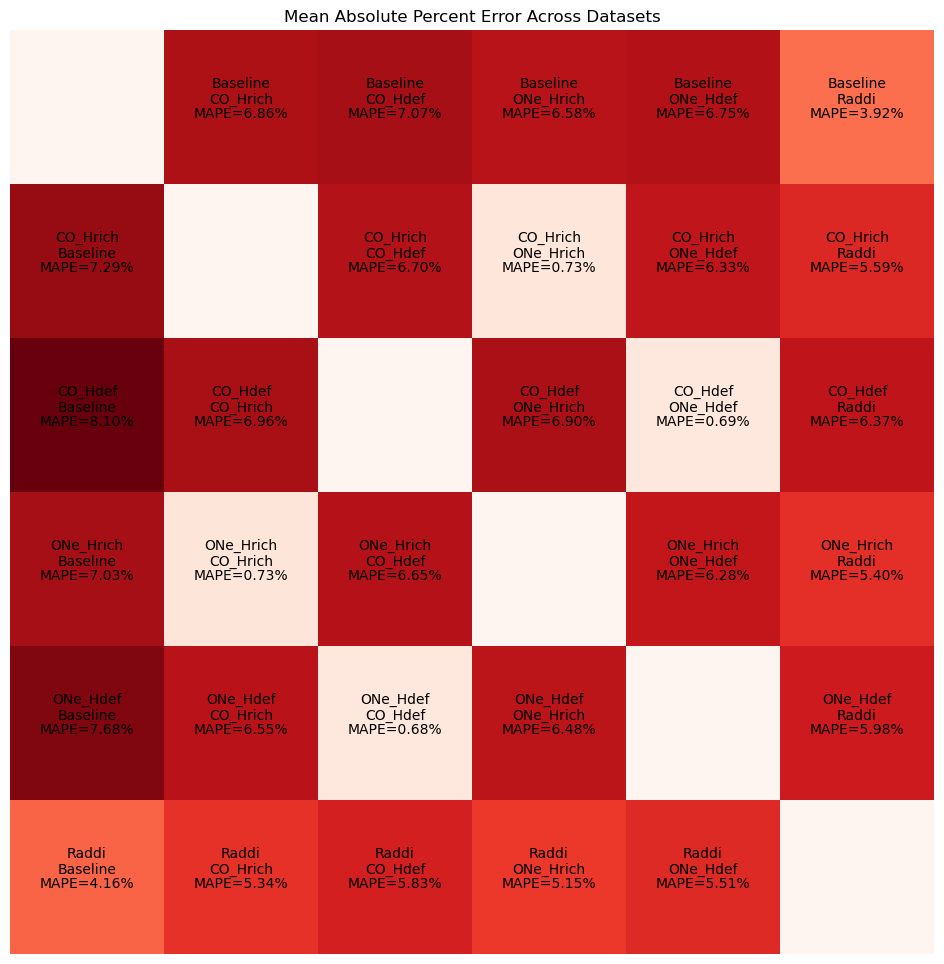

In [15]:
plt.figure(figsize=(12, 12))
plt.imshow(mpe_matrix, cmap='Reds')
for i in range(len(model)):
    for j in range(len(model)):
        if i != j:
            chstr = model[i] + '\n' + model[j]
            plt.text(j,i,chstr, ha='center', va='bottom', color='black')
            plt.text(j, i, f'MAPE={mpe_matrix[i,j]:2.2f}%', ha='center', va='top', color='black')
            #plt.text(j, i, f'MPE={mpe_matrix[i,j]:0.5f}', ha='center', va='top', color='black')
plt.title('Mean Absolute Percent Error Across Datasets')
plt.axis('off')
